In [1]:
!pip install catboost
!pip install optuna

  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=784c27bb34f6b0a6cae97079a3e8e024af563414e2b2da71058c84dae036dbe2
  Stored in directory: c:\users\hpe\appdata\local\pip\cache\wheels\7f\1a\65\84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
# seaborn setting
sns.set_theme(style='whitegrid')
sns.set_palette("twilight")

In [3]:
path = './dataset/물류 유통량 예측 경진대회/'

In [23]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

In [24]:
train.head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [32]:
# column 이름 수정
train = train.rename(columns= {'index' : 'index', 
                       '송하인_격자공간고유번호' : 'send_num',
                       '수하인_격자공간고유번호' : 'rec_num',
                       '물품_카테고리' : 'category',
                       '운송장_건수' : 'inv_cnt'})

test = test.rename(columns= {'index' : 'index', 
                       '송하인_격자공간고유번호' : 'send_num',
                       '수하인_격자공간고유번호' : 'rec_num',
                       '물품_카테고리' : 'category'})

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31684 entries, 0 to 31683
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     31684 non-null  int64 
 1   send_num  31684 non-null  int64 
 2   rec_num   31684 non-null  int64 
 3   category  31684 non-null  object
 4   inv_cnt   31684 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.2+ MB


- 송하인과 수하인의 경우 16자리의 숫자중 앞의 4자리가 격자 번호이다.
- 따라서 앞의 4자리 수만을 가지고 categorical 형식으로 바꾸어 진행하는 것이 좋을 것으로 보인다.

In [34]:
train['send_num'] = train['send_num'].apply(str)
train['rec_num'] = train['rec_num'].apply(str)

test['send_num'] = test['send_num'].apply(str)
test['rec_num'] = test['rec_num'].apply(str)

In [35]:
train['send_num'] = train['send_num'].str.slice(start = 0, stop=4)
train['rec_num'] = train['rec_num'].str.slice(start = 0, stop=4)

test['send_num'] = test['send_num'].str.slice(start = 0, stop=4)
test['rec_num'] = test['rec_num'].str.slice(start = 0, stop=4)

In [46]:
train.head()

,index,send_num,rec_num,category,inv_cnt
0,0,5011,2871,음반,3
1,1,4148,5011,문화컨텐츠,3
2,2,5011,1120,농산물,3
3,3,4127,5011,기타식품,7
4,4,5011,2823,농산물,3


In [37]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     7920 non-null   int64 
 1   send_num  7920 non-null   object
 2   rec_num   7920 non-null   object
 3   category  7920 non-null   object
dtypes: int64(1), object(3)
memory usage: 247.6+ KB


In [58]:
train.groupby('send_num').count()

,index,rec_num,category,inv_cnt
send_num,,,,
1111,47,47,47,47
1114,41,41,41,41
1117,182,182,182,182
1120,44,44,44,44
1121,18,18,18,18
...,...,...,...,...
4887,4,4,4,4
4888,4,4,4,4
4889,2,2,2,2


### 데이터 플랏

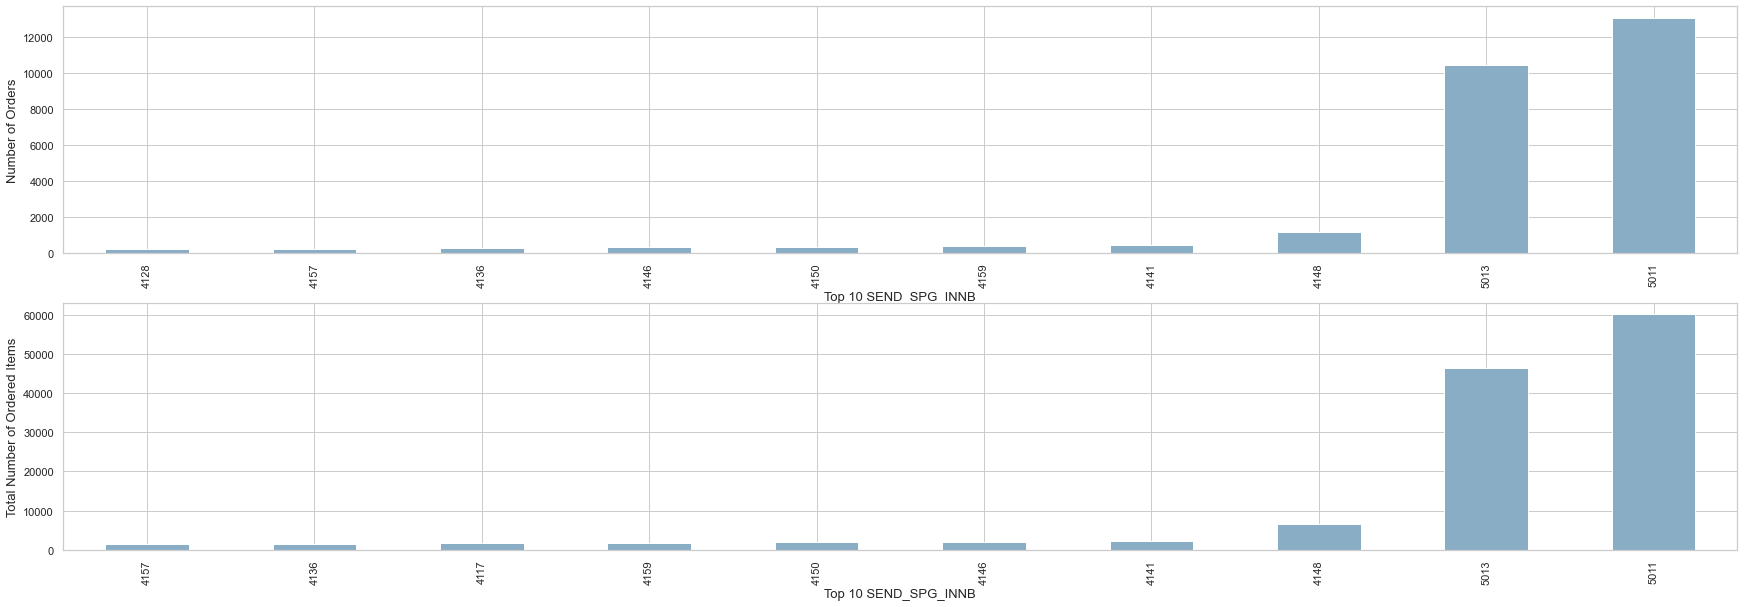

In [43]:
# send 
plt.subplot(2, 1, 1)
order_send = train.groupby('send_num').count()['inv_cnt'].sort_values()
order_send_plot = order_send.tail(10).plot(kind='bar', figsize=(30, 10))
order_send_plot.set_xlabel('Top 10 sended object', fontsize=13)
order_send_plot.set_ylabel('Number of Orders', fontsize=13)

plt.subplot(2, 1, 2)
order_send_total = train.groupby('send_num').sum()['inv_cnt'].sort_values()
order_send_total_plot = order_send_total.tail(10).plot(kind='bar', figsize=(30, 10))
order_send_total_plot.set_xlabel('Top 10 SEND_SPG_INNB', fontsize=13)
order_send_total_plot.set_ylabel('Total Number of Ordered Items', fontsize=13)

plt.show()

In [44]:
print(order_send.tail(10))
print(order_send_total.tail(10))

send_num
4128      213
4157      250
4136      310
4146      338
4150      341
4159      394
4141      472
4148     1199
5013    10431
5011    13030
Name: inv_cnt, dtype: int64
send_num
4157     1419
4136     1514
4117     1795
4159     1826
4150     1992
4146     2012
4141     2256
4148     6470
5013    46515
5011    60067
Name: inv_cnt, dtype: int64


- 상위 두개의 송하인을 제외하면 주문 건수가 높다고 주문량이 높게 나오지는 않는다.

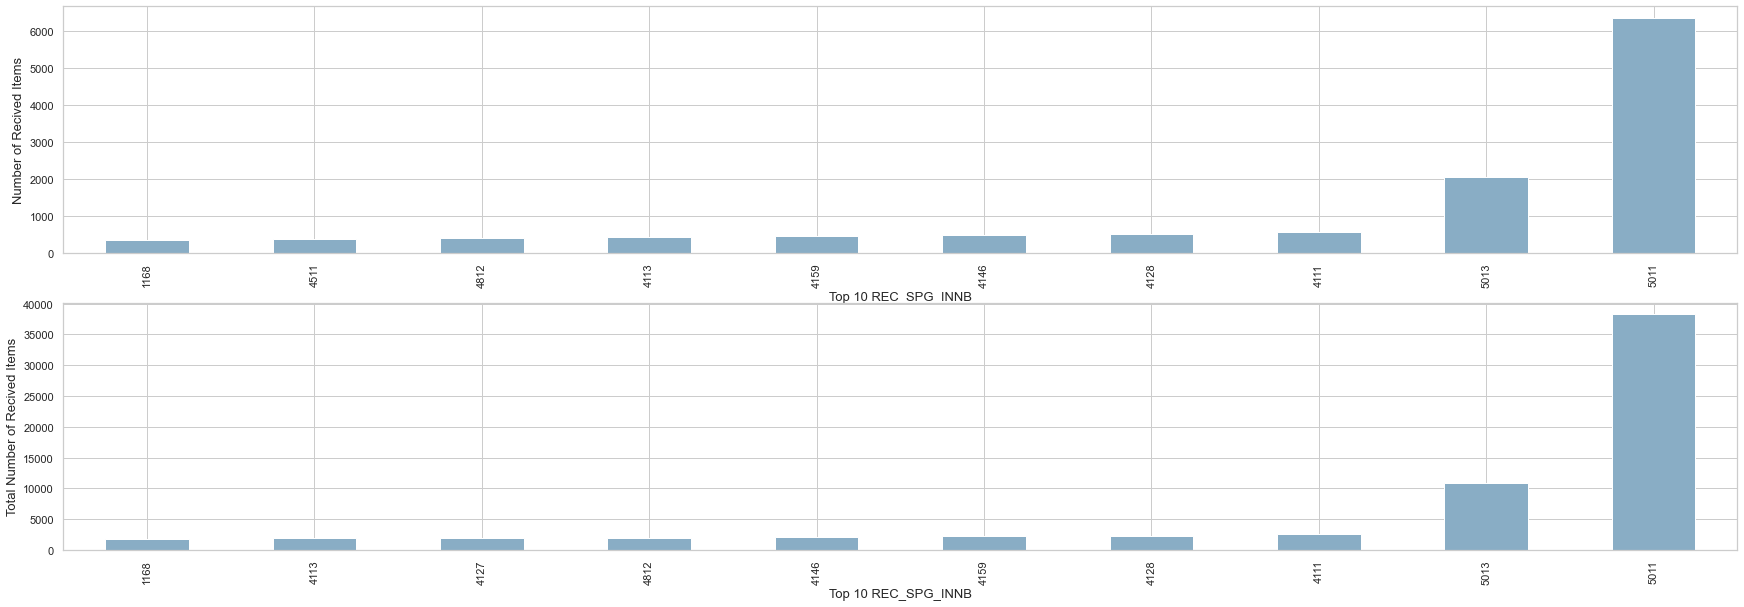

In [41]:
# recieve
plt.subplot(2, 1, 1)
order_recv = train.groupby('rec_num').count()['inv_cnt'].sort_values()
order_recv_plot = order_recv.tail(10).plot(kind='bar', figsize=(30, 10))
order_recv_plot.set_xlabel('Top 10 REC_SPG_INNB', fontsize=13)
order_recv_plot.set_ylabel('Number of Recived Items', fontsize=13)

plt.subplot(2, 1, 2)
order_recv_total = train.groupby('rec_num').sum()['inv_cnt'].sort_values()
order_recv_total_plot = order_recv_total.tail(10).plot(kind='bar', figsize=(30, 10))
order_recv_total_plot.set_xlabel('Top 10 REC_SPG_INNB', fontsize=13)
order_recv_total_plot.set_ylabel('Total Number of Recived Items', fontsize=13)

plt.show()

In [42]:
print(order_recv.tail(10))
print(order_recv_total.tail(10))

rec_num
1168     372
4511     385
4812     404
4113     447
4159     461
4146     506
4128     532
4111     570
5013    2055
5011    6361
Name: inv_cnt, dtype: int64
rec_num
1168     1815
4113     1853
4127     1923
4812     1979
4146     2142
4159     2188
4128     2306
4111     2570
5013    10858
5011    38246
Name: inv_cnt, dtype: int64


- 수하인의 경우 상위 4개의 수하인을 제외하면 주문 횟수가 높다고 전체 주문량이 높게 나오진 않는다.

In [59]:
catb_count = train.groupby('category').count()['inv_cnt'].sort_values(ascending=False)
catb_count_total = train.groupby('category').sum()['inv_cnt'].sort_values(ascending=False)

print(catb_count)
print(catb_count_total)

category
농산물              20321
문화컨텐츠             1091
음료                1034
수산                 860
가공식품               846
                 ...  
태블릿PC/노트북액세서리        4
기타출산/육아              4
선케어                  4
유아가구                 4
스포츠잡화                4
Name: inv_cnt, Length: 100, dtype: int64
category
농산물        87829
음료          5890
가공식품        5766
문화컨텐츠       5429
수산          4880
           ...  
기타출산/육아       22
지갑            22
세탁용품          20
유아가구          13
스포츠잡화         13
Name: inv_cnt, Length: 100, dtype: int64


In [63]:
train.groupby('category').count()

,index,send_num,rec_num,inv_cnt
category,,,,
DIY자재/용품,36,36,36,36
PC,30,30,30,30
PC주변기기,8,8,8,8
가공식품,846,846,846,846
가방,8,8,8,8
...,...,...,...,...
헤어스타일링,6,6,6,6
헤어액세서리,7,7,7,7
헤어케어,46,46,46,46


- 카테고리의 경우 주문 건수가 높을경우 전체 주문량 또한 높게 나온다.

In [64]:
cat_cnt = pd.concat([catb_count, catb_count_total], axis = 1)
cat_cnt

,inv_cnt,inv_cnt
category,,
농산물,20321,87829
문화컨텐츠,1091,5429
음료,1034,5890
수산,860,4880
가공식품,846,5766
...,...,...
태블릿PC/노트북액세서리,4,40
기타출산/육아,4,22
선케어,4,96


## Feature Engineering
- 현재 데이터의 특성을 보면 송하인과 수하인의 경우 주문 건수가 높다고 전체 주문량이 높게 나오지는 않았다.
- 반면에 카테고리의 경우 주문 건수가 높을 경우 전체 주문량 또한 높았다.

<built-in method normal of numpy.random.mtrand.RandomState object at 0x000002B655980B40>
